In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from statsforecast import StatsForecast
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import TimeSeriesSplit
from statsforecast.models import Naive, SeasonalNaive, SeasonalWindowAverage

In [ ]:
historic_df = pd.read_csv(r'Base de Dados//Dados Históricos - Ibovespa.csv', parse_dates=['Data'], index_col='Data')
historic_df = historic_df.sort_index()

historic_df['Var%'] = historic_df['Var%'].str.replace('%', '').str.replace(',', '.').astype(float)

historic_df['Vol.'] = historic_df['Vol.'].str.replace(',', '.')
historic_df['Vol.'] = historic_df['Vol.'].apply(
    lambda x: float(str(x)[:-1].replace(',', '.'))/1_000  if str(x)[-1] == 'K'
    else float(str(x)[:-1].replace(',', '.')) if str(x)[-1] == 'M'
    else float(str(x)[:-1].replace(',', '.')) * 1_000 if str(x)[-1] == 'B'
    else float(str(x).replace(',', '.'))/1_000_000 )

historic_df.rename(columns={'Vol.':'Vol (M)'}, inplace=True)

In [ ]:
historic_df.info()

In [ ]:
historic_df.describe()

In [ ]:
delta_date = historic_df['Último'].iloc[-1] - historic_df['Último'].iloc[0]
line_trend = delta_date/(len(historic_df)-1)

historic_df['Trend'] = (line_trend * range(len(historic_df))) + historic_df['Último'].iloc[0]

In [ ]:
fig, ax = plt.subplots(figsize=(12,6))

# Plot da média móvel da variação percentual no eixo primário
line1, = ax.plot(historic_df.index, historic_df['Var%'].rolling(window=30).mean(), color='blue', label='Variação %')
ax.plot(historic_df.index, historic_df['Var%'].rolling(window=30).mean(), color='blue', label='Variação %')
ax.set_xlabel('Data')
ax.set_ylabel('Variação da Bolsa (%)')
ax.tick_params(axis='y')

# Criação do segundo eixo Y (para o fechamento da bolsa)
ay = ax.twinx()
line2, = ay.plot(historic_df.index, historic_df['Último'].rolling(window=30).mean(), color='red', label='Fechamento Valor')
ay.plot(historic_df.index, historic_df['Último'].rolling(window=30).mean(), color='red', label='Fechamento Valor')
line3, = ay.plot(historic_df.index, historic_df['Trend'].rolling(window=30).mean(), 
                 color='black', linewidth=1, linestyle='--', label='Trend Line')
ay.plot(historic_df.index, historic_df['Trend'].rolling(window=30).mean(),
         color='black', linewidth=1, linestyle='--', label='Trend Line')
ay.set_ylabel('Fechamento da Bolsa')
ay.tick_params(axis='y')

# Título e layout
lines = [line3, line1, line2]
labels = [line.get_label() for line in lines]
ax.legend(lines, labels, loc='upper left')

plt.title('Média Móvel 30 dias - Variação % e Fechamento')
fig.tight_layout()

# Exibir gráfico
plt.show()

In [ ]:

historic_df

In [ ]:
historic_var_df = historic_df[['Var%']]
X = historic_var_df[['Var%']].values

result = adfuller(X)

print("Teste ADF")
print(f"Teste Estatístico: {result[0]}")
print(f"P-Value: {result[1]}")
print("Valores críticos:")

for key, value in result[4].items():
  print(f"\t{key}: {value}")


In [ ]:
# Define training and test sets
train_end = '2025-03-01'
df_train = historic_df.loc[:train_end]
df_test = historic_df.loc[train_end:]

### CRIANDO O NAIVE PREDICT

In [ ]:
naive_pred = pd.Series(index=historic_df.index, dtype='float64')
naive_pred.loc[df_train.index] = historic_df['Último'].shift(1).loc[df_train.index]
last_train_value = historic_df['Último'].loc[df_train.index[-1]]
naive_pred.loc[df_test.index] = last_train_value


# Evaluation
from sklearn.metrics import mean_squared_error

mse_naive = mean_squared_error(df_test['Último'][1:], naive_pred.loc[df_test.index][1:])
print(f'Naive Baseline MSE: {mse_naive}')

In [ ]:
historic_filter = historic_df.tail(60)
delta_date = historic_filter['Último'].iloc[-1] - historic_filter['Último'].iloc[0]
line_trend = delta_date/(len(historic_filter)-1)
historic_filter['Trend'] = (line_trend * range(len(historic_filter))) + historic_filter['Último'].iloc[0]

naive_filter = naive_pred.tail(60)

fig, ax = plt.subplots(figsize=(12,6))

# Fechamento real (rolling)
line2, = ax.plot(historic_filter.index, historic_filter['Último'].rolling(window=30).mean(), color='red', label='Fechamento Act')

# Linha de tendência (rolling)
line3, = ax.plot(historic_filter.index, historic_filter['Trend'].rolling(window=30).mean(), 
                 color='black', linewidth=1, linestyle='--', label='Trend Line')

# Previsão Naive SOMENTE no período de teste (sem rolling para mostrar a linha de previsão)
line4, = ax.plot(df_test.index, naive_filter.loc[df_test.index], color='green', linestyle=':', linewidth=1.5, label='Naive Pred')

ax.set_ylabel('Fechamento da Bolsa')
ax.tick_params(axis='y')

# Título e legenda
lines = [line2, line3, line4]
labels = [line.get_label() for line in lines]
ax.legend(lines, labels, loc='upper left')
plt.title('Média Móvel 30 dias - Variação % e Fechamento com Previsão Naive')
fig.tight_layout()

plt.show()

### CRIANDO XGBoost PREDICT

In [ ]:
historic_df['day'] = historic_df.index.day
historic_df['week_of_year'] = [dt.weekofyear for dt in historic_df.index]
historic_df['month'] = historic_df.index.month
historic_df['year'] = historic_df.index.year


# Plot da ACF e PACF da série diferenciada
plt.figure(figsize=(14, 6))
plot_acf(historic_df["Último"].dropna(), ax=plt.gca(), lags=40)
plt.title("Função de Autocorrelação (ACF)")


n_lags = 40
for lag in range(1, n_lags + 1):
    historic_df[f'lag_{lag}'] = historic_df['Último'].shift(lag)


# Rolling statistics
historic_df[f'rolling_mean_{n_lags}'] = historic_df['Último'].rolling(window=n_lags).mean().shift(1)
historic_df[f'rolling_std_{n_lags}'] = historic_df['Último'].rolling(window=n_lags).std().shift(1)

# Exponential Moving Averages (EMA)
historic_df[f'ema_{n_lags}'] = historic_df['Último'].ewm(span=n_lags).mean().shift(1)
historic_df[f'ema_std_{n_lags}'] = historic_df['Último'].ewm(span=n_lags).std().shift(1)



from scipy.signal import periodogram
frequency, power = periodogram(historic_df['Último'].dropna(), fs=1)

freq = frequency[np.argmax(power)]
period = 1 / freq

print(f'Period: {period} days')

historic_df['fourier_sin'] = np.sin(2 * np.pi * freq * np.arange(len(historic_df)))
historic_df['fourier_cos'] = np.cos(2 * np.pi * freq * np.arange(len(historic_df)))


predictors = [
    'day',
    'week_of_year',
    'month',
    'year',
    *['lag_{}'.format(i) for i in range(1, n_lags + 1)],
    'rolling_mean_{n_lags}'.format(n_lags=n_lags),
    'rolling_std_{n_lags}'.format(n_lags=n_lags),
    'ema_{n_lags}'.format(n_lags=n_lags),
    'ema_std_{n_lags}'.format(n_lags=n_lags),
    'fourier_sin',
    'fourier_cos',
]



In [ ]:
df_train = historic_df.loc[:train_end]
df_test = historic_df.loc[train_end:]

# Define features and target
X_train = df_train[predictors]
y_train = df_train['Último']
X_test = df_test[predictors]
y_test = df_test['Último']

# TimeSeriesSplit for validation
tscv = TimeSeriesSplit(n_splits=100)
xgb = XGBRegressor(objective='reg:squarederror')

# Train with cross-validation
xgb_models = []
mse = []
count = 0
for train_idx, val_idx in tscv.split(X_train):
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
    xgb.fit(X_tr, y_tr)
    val_pred = xgb.predict(X_val)
    # print(f'{count} Validation MSE: {mean_squared_error(y_val, val_pred)}')
    count = count + 1 
    mse.append(mean_squared_error(y_val, val_pred))
    xgb_models.append(xgb)

best_model_idx = mse.index(min(mse))
print(f'Best Model Idx: {best_model_idx}')

xgb = xgb_models[best_model_idx]

# Predict on the test set
xgb_pred = xgb.predict(X_test)
mse_xgb = mean_squared_error(y_test, xgb_pred)
print(f'XGBoost MSE: {mse_xgb}')

In [ ]:
xgb_pred_series = pd.Series(xgb_pred, index=df_test.index, name='pred')
xgb_pred_df = xgb_pred_series.astype('float64')

xgb_pred_df

C:\Users\dhlui\AppData\Local\Temp\ipykernel_15512\862531456.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  historic_filter['Trend'] = (line_trend * range(len(historic_filter))) + historic_filter['Último'].iloc[0]


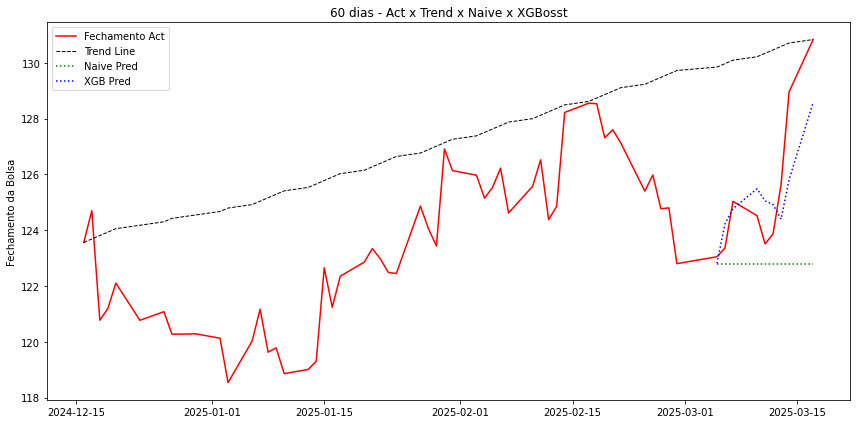

In [82]:
historic_filter = historic_df.tail(60)
delta_date = historic_filter['Último'].iloc[-1] - historic_filter['Último'].iloc[0]
line_trend = delta_date/(len(historic_filter)-1)
historic_filter['Trend'] = (line_trend * range(len(historic_filter))) + historic_filter['Último'].iloc[0]

naive_filter = naive_pred.tail(60)


fig, ax = plt.subplots(figsize=(12,6))

# Fechamento real (rolling)
line2, = ax.plot(historic_filter.index, historic_filter['Último'], color='red', label='Fechamento Act')

# Linha de tendência (rolling)
line3, = ax.plot(historic_filter.index, historic_filter['Trend'], 
                 color='black', linewidth=1, linestyle='--', label='Trend Line')

# Previsão Naive SOMENTE no período de teste (sem rolling para mostrar a linha de previsão)
line4, = ax.plot(df_test.index, naive_filter.loc[df_test.index], color='green', linestyle=':', linewidth=1.5, label='Naive Pred')

# Previsão XGBoost
line5, = ax.plot(df_test.index, xgb_pred_df.loc[df_test.index], color='blue', linestyle=':', linewidth=1.5, label='XGB Pred')

ax.set_ylabel('Fechamento da Bolsa')
ax.tick_params(axis='y')

# Título e legenda
lines = [line2, line3, line4, line5]  # A lista de objetos de linha

# Usando get_label() corretamente
labels = [line.get_label() for line in lines]
ax.legend(lines, labels, loc='upper left')

plt.title('60 dias - Act x Trend x Naive x XGBosst')
fig.tight_layout()

plt.show()

### CRIANDO ARIMA PREDCT

In [ ]:
# Plot da ACF e PACF da série diferenciada
plt.figure(figsize=(14, 6))
plt.subplot(121)
plot_acf(historic_df["Último"].dropna(), ax=plt.gca(), lags=40)
plt.title("Função de Autocorrelação (ACF)")
plt.subplot(122)
plot_pacf(historic_df["Último"].dropna(), ax=plt.gca(), lags=40)
plt.title("Função de Autocorrelação Parcial (PACF)")
plt.show()

In [75]:
p = 3 
d = 1
q = 40

model_arima = ARIMA(df_train["Último"], order=(p, d, q))
resultado_arima = model_arima.fit()

arima_pred = resultado_arima.predict(start=len(df_train), end=len(df_train) + len(df_test) - 1)

arima_mse = mean_squared_error(y_test, arima_pred)
print(f'ARIMA MSE: {arima_mse}')

c:\Users\dhlui\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\dhlui\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\dhlui\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\dhlui\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization

ARIMA MSE: 10.299340727517688


c:\Users\dhlui\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\dhlui\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [81]:
arima_pred.index = df_test.index 
arima_pred_series = pd.Series(arima_pred, index=df_test.index, name='pred')
arima_pred_df = arima_pred_series.astype('float64')

arima_pred_df


Data
2025-03-05    122.947099
2025-03-06    123.843921
2025-03-07    123.553491
2025-03-10    123.946944
2025-03-11    123.561493
2025-03-12    123.176676
2025-03-13    123.112457
2025-03-14    123.365418
2025-03-17    123.635989
Name: pred, dtype: float64

C:\Users\dhlui\AppData\Local\Temp\ipykernel_15512\2016944461.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  historic_filter['Trend'] = (line_trend * range(len(historic_filter))) + historic_filter['Último'].iloc[0]


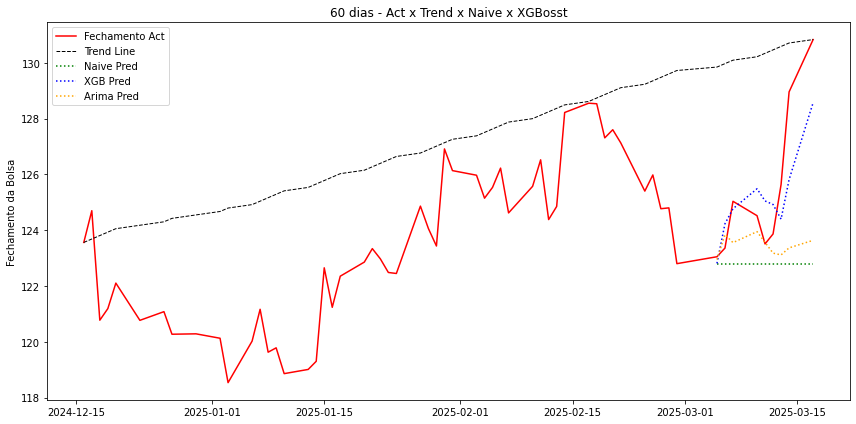

In [84]:
historic_filter = historic_df.tail(60)
delta_date = historic_filter['Último'].iloc[-1] - historic_filter['Último'].iloc[0]
line_trend = delta_date/(len(historic_filter)-1)
historic_filter['Trend'] = (line_trend * range(len(historic_filter))) + historic_filter['Último'].iloc[0]

naive_filter = naive_pred.tail(60)


fig, ax = plt.subplots(figsize=(12,6))

# Fechamento real (rolling)
line2, = ax.plot(historic_filter.index, historic_filter['Último'], color='red', label='Fechamento Act')

# Linha de tendência (rolling)
line3, = ax.plot(historic_filter.index, historic_filter['Trend'], 
                 color='black', linewidth=1, linestyle='--', label='Trend Line')

# Previsão Naive SOMENTE no período de teste (sem rolling para mostrar a linha de previsão)
line4, = ax.plot(df_test.index, naive_filter.loc[df_test.index], color='green', linestyle=':', linewidth=1.5, label='Naive Pred')

# Previsão XGBoost
line5, = ax.plot(df_test.index, xgb_pred_df.loc[df_test.index], color='blue', linestyle=':', linewidth=1.5, label='XGB Pred')

# Previsão Arima
line6, = ax.plot(df_test.index, arima_pred_df.loc[df_test.index], color='orange', linestyle=':', linewidth=1.5, label='Arima Pred')


ax.set_ylabel('Fechamento da Bolsa')
ax.tick_params(axis='y')

# Título e legenda
lines = [line2, line3, line4, line5, line6]  # A lista de objetos de linha

# Usando get_label() corretamente
labels = [line.get_label() for line in lines]
ax.legend(lines, labels, loc='upper left')

plt.title('60 dias - Act x Trend x Naive x XGBosst')
fig.tight_layout()

plt.show()